In [1]:
import numpy as np
import sys
import time
# importing S4
sys.path.append('/home/pellegr/electrodynamics/st-matrix/S4/build/lib.linux-x86_64-2.7')
import S4
# importing py-matrix parent folder
sys.path.append('/home/pellegr/electrodynamics/st-matrix')
sys.path.append('/home/pellegr/electrodynamics/st-matrix/mans/')
import py_matrix as pm
import seaborn as sns

# multiprocessing
from multiprocessing import cpu_count
from joblib import Parallel, delayed
num_cores=cpu_count()/2

In [2]:
# linking diagnostics
from distutils import sysconfig
print 'LDSHARED',sysconfig.get_config_var('LDSHARED')
print 'CC',sysconfig.get_config_var('CC')
print 'CFLAGS',sysconfig.get_config_var('CFLAGS')
print 'LDFLAGS',sysconfig.get_config_var('LDFLAGS')

LDSHARED gcc -pthread -shared
CC gcc -pthread
CFLAGS -fno-strict-aliasing -g -O2 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes
LDFLAGS 


## inputs

In [3]:
#------building the optical constant database------
eps_db_out=pm.mat.generate_eps_db('/home/pellegr/electrodynamics/st-matrix/py_matrix/materials/',ext='*.edb')
eps_files,eps_names,eps_db=eps_db_out['eps_files'],eps_db_out['eps_names'],eps_db_out['eps_db']

In [4]:
T_raw=np.loadtxt('/home/pellegr/electrodynamics/st-matrix/S4/NHA/Transmittance.dat',skiprows=2)
R_raw=np.loadtxt('/home/pellegr/electrodynamics/st-matrix/S4/NHA/Reflectance.dat',skiprows=3)
A_raw=np.loadtxt('/home/pellegr/electrodynamics/st-matrix/S4/NHA/Absorbance.dat',skiprows=3)

In [5]:
# stack material an thicknesses
stack=['e_vacuum','e_au','e_sio2'];
d_list=[0.0,150.0,0.0];

# incident angles
theta_0=0.0
phi_0=0.0

# wavelengths
v_wl=np.linspace(400,1200,num_cores*4)

# nanohole array r and pitch in nm
nh_p=535
nh_r=150
num=320


# conversion factor
cf=1e-3

## S4 Solution

In [6]:
S=S4.New(Lattice=((nh_p*cf,0),(nh_p*cf*np.cos(np.pi/3.0),nh_p*cf*np.sin(np.pi/3.0))), NumBasis=num)
#S=S4.New(Lattice=((nh_p*cf,0),(0,nh_p*cf)), NumBasis=100)

# retrieving optical constants at wl from the database
e_list=np.array(pm.mat.db_to_eps(v_wl[0],eps_db,stack))

S.SetMaterial('Air',e_list[0])
S.SetMaterial('Au',e_list[1])
S.SetMaterial('Glass',e_list[2])
#S.SetMaterial('Glass',2.25)

S.AddLayer('Inc',d_list[0]*cf,'Air')

S.AddLayer('Slab',d_list[1]*cf,'Au')
S.SetRegionCircle('Slab', 'Air', (0.0,0.0), nh_r*cf)

S.AddLayer('Sub',d_list[2]*cf,'Glass')

S.SetExcitationPlanewave((theta_0,phi_0),
                                              1.0,
                                              0.0)

S.SetOptions(PolarizationDecomposition = True,PolarizationBasis='Jones')

In [7]:
def fluxes(wl):
    # retrieving optical constants at wl from the database
    e_list=np.array(pm.mat.db_to_eps(wl,eps_db,stack))

    S.SetMaterial('Air',e_list[0])
    S.SetMaterial('Au',e_list[1])
    S.SetMaterial('Glass',e_list[2])

    S.SetFrequency(1.0/(wl*cf))
    forw_1,back_1 = S.GetPowerFlux(Layer = 'Inc', zOffset = 0)
    forw_2,back_2 = S.GetPowerFlux(Layer = 'Sub', zOffset = 0)

    return forw_1,back_1,forw_2,back_2

In [8]:
%%time
d_sweep=np.array([50.0,100.0,150.0])
r_sweep=np.array([100.0,150.0,200.0])

out=[]
for d in d_sweep:
    for r in r_sweep:
        tic=time.time()
        S=S4.New(Lattice=((nh_p*cf,0),(nh_p*cf*np.cos(np.pi/3.0),nh_p*cf*np.sin(np.pi/3.0))), NumBasis=num)

        # retrieving optical constants at wl from the database
        e_list=np.array(pm.mat.db_to_eps(v_wl[0],eps_db,stack))

        # materials
        S.SetMaterial('Air',e_list[0])
        S.SetMaterial('Au',e_list[1])
        S.SetMaterial('Glass',e_list[2])

        # layers
        S.AddLayer('Inc',d_list[0]*cf,'Air') # 1
        S.AddLayer('Slab',d*cf,'Au') # 2
        S.SetRegionCircle('Slab', 'Air', (0.0,0.0), r*cf)
        S.AddLayer('Sub',d_list[2]*cf,'Glass') # 3

        # incident wave
        S.SetExcitationPlanewave((theta_0,phi_0),1.0,0.0)

        # options
        S.SetOptions(PolarizationDecomposition = True,PolarizationBasis='Jones')
        
        # computation
        result=Parallel(n_jobs=num_cores)(delayed(fluxes)(wl) for wl in v_wl)
        out.append(np.array(result))
        toc=time.time()
        
        print "d,r,time",d,r,toc-tic,time.ctime()

d,r,time 50.0 100.0 458.074517965 Thu Jan 22 15:37:22 2015
d,r,time 50.0 150.0 468.849589109 Thu Jan 22 15:45:11 2015
d,r,time 50.0 200.0 468.710162878 Thu Jan 22 15:53:00 2015
d,r,time 100.0 100.0 465.510053873 Thu Jan 22 16:00:45 2015
d,r,time 100.0 150.0 460.063019991 Thu Jan 22 16:08:25 2015
d,r,time 100.0 200.0 465.293308973 Thu Jan 22 16:16:11 2015
d,r,time 150.0 100.0 459.763191938 Thu Jan 22 16:23:50 2015
d,r,time 150.0 150.0 468.649683237 Thu Jan 22 16:31:39 2015
d,r,time 150.0 200.0 458.223402023 Thu Jan 22 16:39:17 2015
CPU times: user 11.5 s, sys: 6.47 s, total: 17.9 s
Wall time: 1h 9min 33s


In [9]:
v_R_s4=[]
v_T_s4=[]
for data in np.array(out):
    
    # power fluxes
    v_fw_1=data[:,0]
    v_bw_1=data[:,1]
    v_fw_2=data[:,2]
    v_bw_2=data[:,3]
    
    # reflectance
    v_R_s4.append(-v_bw_1/v_fw_1)
    
    # transmittance
    v_T_s4.append(v_fw_2/v_fw_1)
v_R_s4,v_T_s4 = np.array(v_R_s4),np.array(v_T_s4)

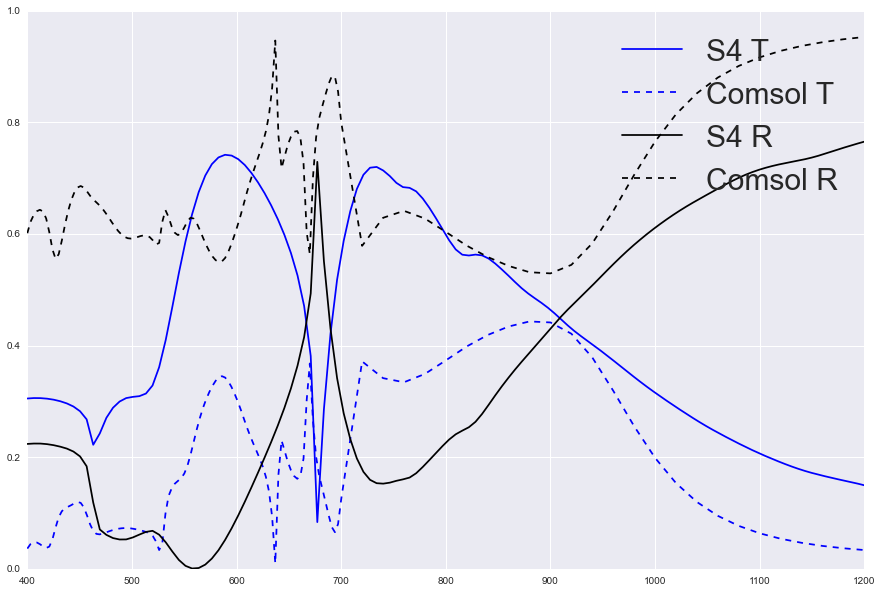

In [18]:
plt.figure(1,figsize(15,10));
index=8
plt.plot(v_wl,v_T_s4[index],'b',
         T_raw[:,0],T_raw[:,index+1],'b--',
         v_wl,v_R_s4[index],'k',
         R_raw[:,0],R_raw[:,index+1],'k--'
        );
plt.legend(('S4 T','Comsol T','S4 R','Comsol R'),fontsize=30);
plt.ylim(0.0,1.0);

In [19]:
# saving
T_data=np.real(np.vstack((v_wl,v_T_s4)).T)
R_data=np.real(np.vstack((v_wl,v_R_s4)).T)
np.savetxt('/home/pellegr/electrodynamics/st-matrix/S4/NHA/T_t_r_systematic.txt',T_data)
np.savetxt('/home/pellegr/electrodynamics/st-matrix/S4/NHA/R_t_r_systematic.txt',R_data)

In [33]:
%%time
d_sweep=np.array([50.0,100.0,150.0])
r_sweep=np.array([100.0,150.0,200.0])
v_x=np.linspace(-nh_p/2.0,nh_p/2.0,1000)
wl_eps=850

out_eps=[]
for d in d_sweep:
    for r in r_sweep:
        tic=time.time()
        S=S4.New(Lattice=((nh_p*cf,0),(nh_p*cf*np.cos(np.pi/3.0),nh_p*cf*np.sin(np.pi/3.0))), NumBasis=1000)

        # retrieving optical constants at wl from the database
        e_list=np.array(pm.mat.db_to_eps(wl_eps,eps_db,stack))

        # materials
        S.SetMaterial('Air',e_list[0])
        S.SetMaterial('Au',e_list[1])
        S.SetMaterial('Glass',e_list[2])

        # layers
        S.AddLayer('Inc',d_list[0]*cf,'Air') # 1
        S.AddLayer('Slab',d*cf,'Au') # 2
        S.SetRegionCircle('Slab', 'Air', (0.0,0.0), r*cf)
        S.AddLayer('Sub',d_list[2]*cf,'Glass') # 3

        # incident wave
        S.SetExcitationPlanewave((theta_0,phi_0),1.0,0.0)

        # options
        S.SetOptions(PolarizationDecomposition = True,PolarizationBasis='Jones')
        
        # computation
        result=np.array([S.GetEpsilon(x, 0.0, 0.020) for x in v_x])
        out_eps.append(result)
        toc=time.time()
        
        print "d,r,time",d,r,toc-tic,time.ctime()

d,r,time 50.0 100.0 3.44130206108 Thu Jan 22 17:49:25 2015
d,r,time 50.0 150.0 4.09250092506 Thu Jan 22 17:49:29 2015
d,r,time 50.0 200.0 4.02325201035 Thu Jan 22 17:49:33 2015
d,r,time 100.0 100.0 3.44312405586 Thu Jan 22 17:49:36 2015
d,r,time 100.0 150.0 4.08563303947 Thu Jan 22 17:49:40 2015
d,r,time 100.0 200.0 4.02480792999 Thu Jan 22 17:49:44 2015
d,r,time 150.0 100.0 3.43880701065 Thu Jan 22 17:49:48 2015
d,r,time 150.0 150.0 4.08618688583 Thu Jan 22 17:49:52 2015
d,r,time 150.0 200.0 4.01658010483 Thu Jan 22 17:49:56 2015
CPU times: user 34.7 s, sys: 0 ns, total: 34.7 s
Wall time: 34.7 s


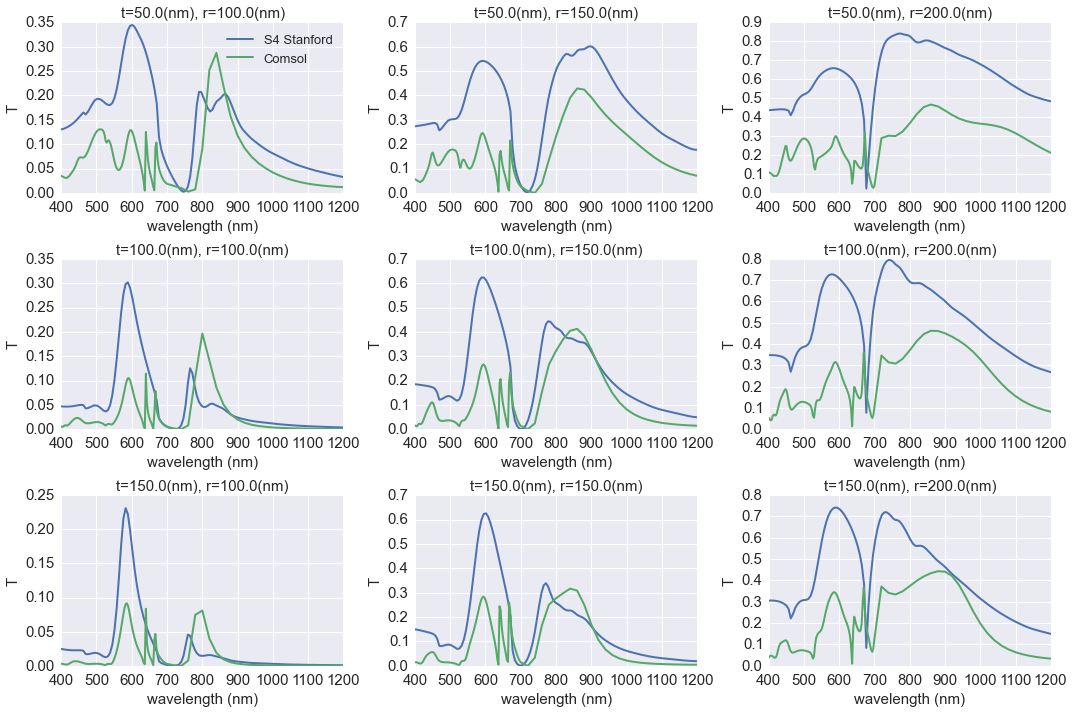

In [56]:
f_size=15;
f_size_ticks=15;
i=0
for d in d_sweep:
    for r in r_sweep:
        plt.subplot(3,3,i+1)
        plt.plot(v_wl,v_T_s4[i],
                 T_raw[:,0],T_raw[:,i+1],
                 linewidth=2.0)
        plt.ylim(ymin=0.0)

        # plt title
        plt.title('t=' + str(d) + '(nm), r=' + str(r) + '(nm)',fontsize=f_size)

        # axes labels
        plt.xlabel(r'wavelength (nm)', fontsize=f_size)
        plt.ylabel(r'T', fontsize=f_size)

        # ticks
        plt.xticks(fontsize=f_size_ticks)
        plt.yticks(fontsize=f_size_ticks)

        # legend
        if i==0:
            plt.legend(('S4 Stanford','Comsol'),fontsize=f_size-2)
        
        plt.tight_layout()
        
        
        i=i+1
plt.savefig('/home/pellegr/electrodynamics/st-matrix/S4/NHA/T.png',bbox_inches='tight',dpi=300)

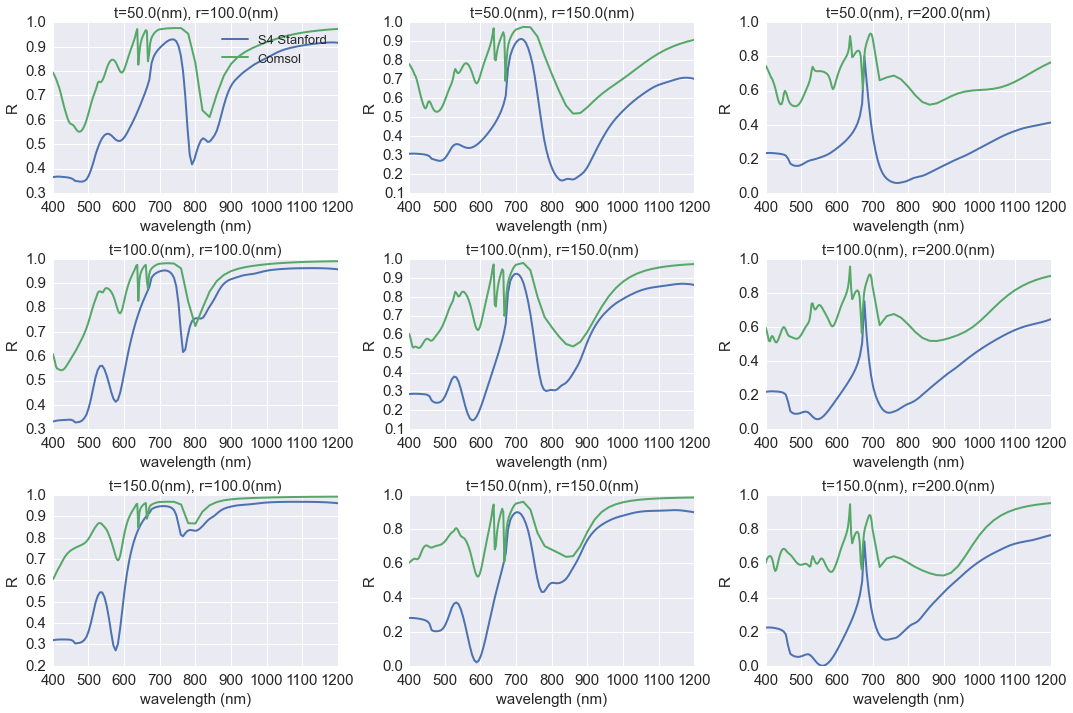

In [57]:
f_size=15;
f_size_ticks=15;
i=0
for d in d_sweep:
    for r in r_sweep:
        plt.subplot(3,3,i+1)
        plt.plot(v_wl,v_R_s4[i],
                 R_raw[:,0],R_raw[:,i+1],
                 linewidth=2.0)
        plt.ylim(ymax=1.0)

        # plt title
        plt.title('t=' + str(d) + '(nm), r=' + str(r) + '(nm)',fontsize=f_size)

        # axes labels
        plt.xlabel(r'wavelength (nm)', fontsize=f_size)
        plt.ylabel(r'R', fontsize=f_size)

        # ticks
        plt.xticks(fontsize=f_size_ticks)
        plt.yticks(fontsize=f_size_ticks)

        # legend
        if i==0:
            plt.legend(('S4 Stanford','Comsol'),fontsize=f_size-2)
        
        plt.tight_layout()
        
        
        i=i+1
plt.savefig('/home/pellegr/electrodynamics/st-matrix/S4/NHA/R.png',bbox_inches='tight',dpi=300)